# Correlated Carboard
## What Factors Are Impacted COVID19 Virulence?

*A visual analysis of potential factors impacting the virulence of COVID19 using the `see19` python package and dataset [available here](https://github.com/ryanskene/see19).*

In [1]:
from datetime import datetime as dt
print ('Last Updated: ', dt.now().strftime('%b %d, %Y'))

Last Updated:  May 08, 2020


The `see19` dataset aggregates case and fatality counts with a number of exogenous factors for each region and can be used to explore the impacts of these factors on COVID19 virulence, both in isolation and together.

The `heatmap` attribute of the `CaseStudy` class is a helpful tool for this purpose.

First, get the baseframe.

In [2]:
%matplotlib inline 
from see19 import CaseStudy, get_baseframe, agg_to_country_level
baseframe = get_baseframe()

Then instantiate a `CaseStudy` object. Throw in a number of different factors and work with same instance for all of the analysis. 

Capturerd are the top 300 regions in terms of population, after excluding certain regions.

Note that we will be using `city_dens`, seen also as `city_KM2`, to adjust fatality and case amounts. Recall that `city_dens` is the density of the largest city of the region. Essentially, we use the largest city as a proxy for density, as the vast majority of cases have been in more populous centers.

A much better approach to density would be to use county level data, however, to my knowledge, no such data exists for global cases.

In [3]:
excluded_countries = ['China'] # because China is so reliable ......
excluded_regions = ['Bermuda', 'Isle of Man', 'Channel Islands'] # these have issues in the cause of death data
excluded_regions += ['Russia'] # Russia does poorly on the city density factor 

df_ex = baseframe[~baseframe['country'].isin(excluded_countries)]
df_ex = df_ex[~df_ex.region_name.isin(excluded_regions)]

regions = df_ex.sort_values('population', ascending=False).region_name.unique().tolist()[:300]

factors_with_dmas = ['uvb', 'temp']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
mobi_dmas = {'transit': 28, 'retail_n_rec': 28}
factors = factors_with_dmas + CaseStudy.MOBIS + ['A15_34B', 'A65PLUSB', 'A75PLUSB'] + ['visitors', 'gdp'] + CaseStudy.MAJOR_CAUSES

casestudy = CaseStudy(
    baseframe, regions=regions, count_dma=21, factors=factors, factor_dmas=factor_dmas, 
    mobi_dmas=mobi_dmas, start_hurdle=1, start_factor='deaths', lognat=True,
)

## Cases and Fatalities
This is a good sanity check. I have used fatality for the most part in my analysis, reasoning that it suffered less from the issue of inconsistent testing across regions and at various times within regions.

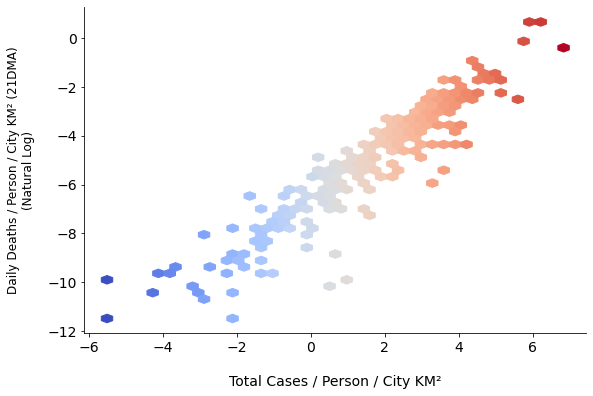

In [6]:
title = 'Max Daily Fatalities v Transit Mobility v Temperature'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'comp_factor': 'cases_per_person_per_city_KM2_lognat',
    'comp_factor_start': 'max',
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 14, 'fs_ylabel': 12, 'fs_clabel': 10,
    'width': 9, 'height': 6,
    'hexsize': 40,
}
plt = casestudy.heatmap.make(**kwargs)

In the above table, we can see that cases correlate nicely with fatalities although note this is a **log** scale on both axis so you can see that some regions had signficantly lower fatalities for the same level of cases and vice versa

We can include a 3rd factor `temp` on a 28-day moving average as of the date of the `start_hurdle` for the region (selected via `color_factor_start: start_hurdle`).

We can see that warmer regions tend to have fewer cases and fewer fatalities.

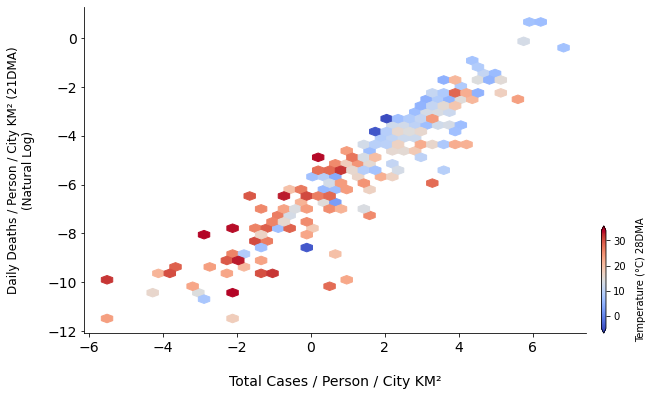

In [7]:
kwargs['color_factor'] = 'temp_dma'
kwargs['color_factor_start'] = 'start_hurdle'
plt = casestudy.heatmap.make(**kwargs)

We can look at other factors, such a region's proportion of deaths due to heart disease via `circul_%`.

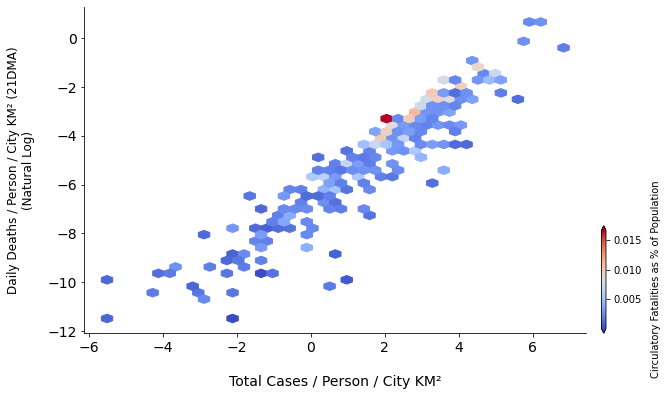

In [8]:
regs = [region for region in regions if region not in ['Czechia', 'Burma']] # removed as they| are extreme outliers. potential error
kwargs['color_factor'] = 'circul_%'
kwargs['color_factor_start'] = 'start_hurdle'
plt = casestudy.heatmap.make(regions=regs, **kwargs)

There is a fairly light correlation here between circulatory diseases and case / fatality counts, in particular a set of regions with significantly higher levels of circulatory deaths spotted in `red` above.

We can see from the `df_hm` attribute that these regions are almost all stats in Italy.

***NOTE*** this feels like it must be an error. If you check general statistics on heart disease in Italy, you will find that it is a bit more middle of the pact than this seems to suggest. I have noted it as an issue for further investigation.

In [9]:
casestudy.heatmap.df_hm.sort_values(by='circul_%', ascending=False).iloc[:10]

,region_id,region_name,deaths_new_dma_per_person_per_city_KM2_lognat,cases_per_person_per_city_KM2_lognat,circul_%
10,42,Valle d'Aosta,-3.343598,2.110229,0.016663
1,33,Molise,-5.111753,1.084847,0.011998
67,286,Liguria,-3.025962,2.690548,0.011209
63,282,Abruzzo,-3.069427,2.760567,0.010927
71,290,Umbria,-3.987352,2.412431,0.010419
68,287,Marche,-2.315180,3.166951,0.010078
5,37,Basilicata,-4.406363,1.582598,0.010020
64,283,Calabria,-4.073325,1.883192,0.009981
7,39,Friuli Venezia Giulia,-3.304597,2.779933,0.009800
8,40,Piemonte,-1.912270,3.947658,0.009603


## Social Distancing
Next we'll look at the impact of social distancing on peak fatality rates by considering changes in transit mobility according to Google.

We use the `transit` factor and find the 28-day moving average of the data. By selecting `comp_factor_start: max`, we can choose the 28DMA of `transit` on the day of peak fatalities. 

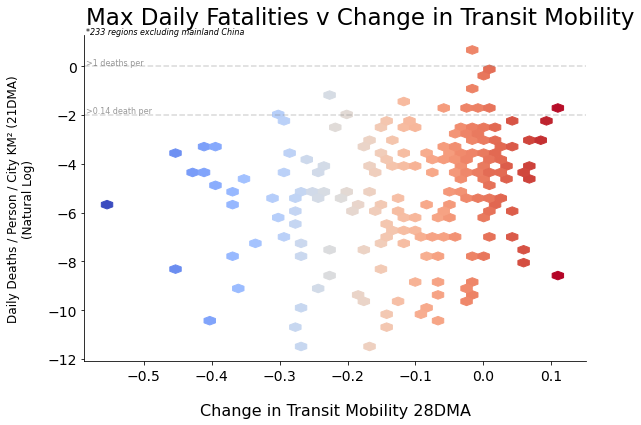

In [10]:
title = 'Max Daily Fatalities v Change in Transit Mobility'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'comp_factor': 'transit_dma',
    'comp_factor_start': 'max',
    'annotations': [
        [-.585, 1.98, title, {'color': 'black', 'fontsize': 23, 'ha': 'left', 'va': 'center',}],
        [-.585, 1.42, note, {'color': 'black', 'fontsize': 8, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
        [-.585, 0.14, '>1 deaths per', {'color': 'black', 'fontsize': 8, 'ha': 'left', 'va': 'center', 'alpha': .4,}],
        [-.585, -1.82, '>0.14 death per', {'color': 'black', 'fontsize': 8, 'ha': 'left', 'va': 'center', 'alpha': .4,}],
    ],
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 16, 'fs_ylabel': 12, 'fs_clabel': 10,
    'width': 9, 'height': 6,
    'hlines': [0, -2], 'hline_alpha': .3,
    'hexsize': 40,
}
plt = casestudy.heatmap.make(**kwargs)

As discussed in [How Effective Is Social Distancing?](https://ryanskene.github.io/see19/analysis/How%20Effective%20Is%20Social%20Distancing%3F.html), it is not all that clear how impactful social distancing has been on fatality rates in different regions.

This time lets color-map to population age.

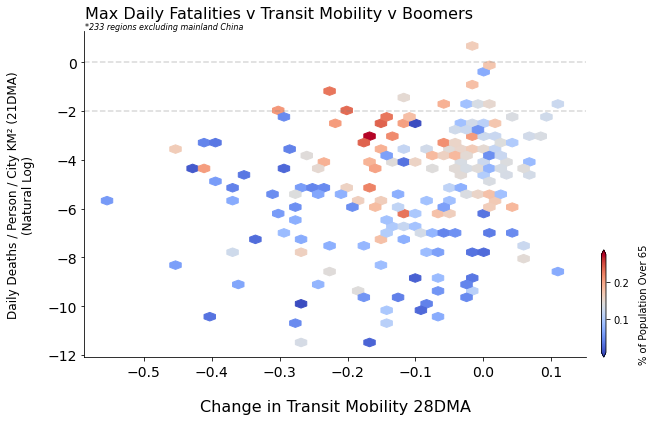

In [11]:
title = 'Max Daily Fatalities v Transit Mobility v Boomers'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)
kwargs = {
    **kwargs,
    'color_factor': 'A65PLUSB_%',
    'color_factor_start': 'start_hurdle',
    'annotations': [
        [-30.4, .93, title, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center',}],
        [-30.4, .895, note, {'color': 'black', 'fontsize': 8, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
    ],
}
plt = casestudy.heatmap.make(**kwargs)

We can see a pretty clear impact of population age now as well. In regions that had lower declines in transit mobility (i.e. change closer to 0), it appears that it was the regions with older populations that were the most impacted.

We can also look at the impact of Retail n Recreation Mobility, color-mapped to the millenial population this time.

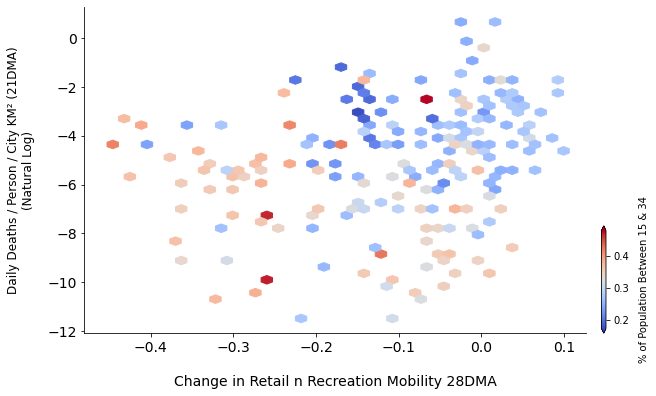

In [12]:
title = 'Max Daily Fatalities v Change in Retail n Recreation Mobility'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'comp_factor': 'retail_n_rec_dma',
    'comp_factor_start': 'max',
    'color_factor': 'A15_34B_%',
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 14, 'fs_ylabel': 12, 'fs_clabel': 10,
    'width': 9, 'height': 6,
    'hexsize': 40,
}
plt = casestudy.heatmap.make(**kwargs)

We can see a modest correlation between retail and recreational mobility and lower fatality rates, at least at the high end of the range. We can also see that the millenial age group is associated with lower fatalities, at least where mobility is less constrained.

# Temperature and Population

We have seen over and over that temperature and population appear to be correlated with lower death rates.

So now we will plot them together. First with `A65PLUSB` on the x-axis and `temp_dma` as the color-map.

**Note** I have added a `rects` option to `make` that creates highlighted areas in the graph and provides descriptive statistics about those regions. The highlighted areas can be customized by editing `box_range` below.

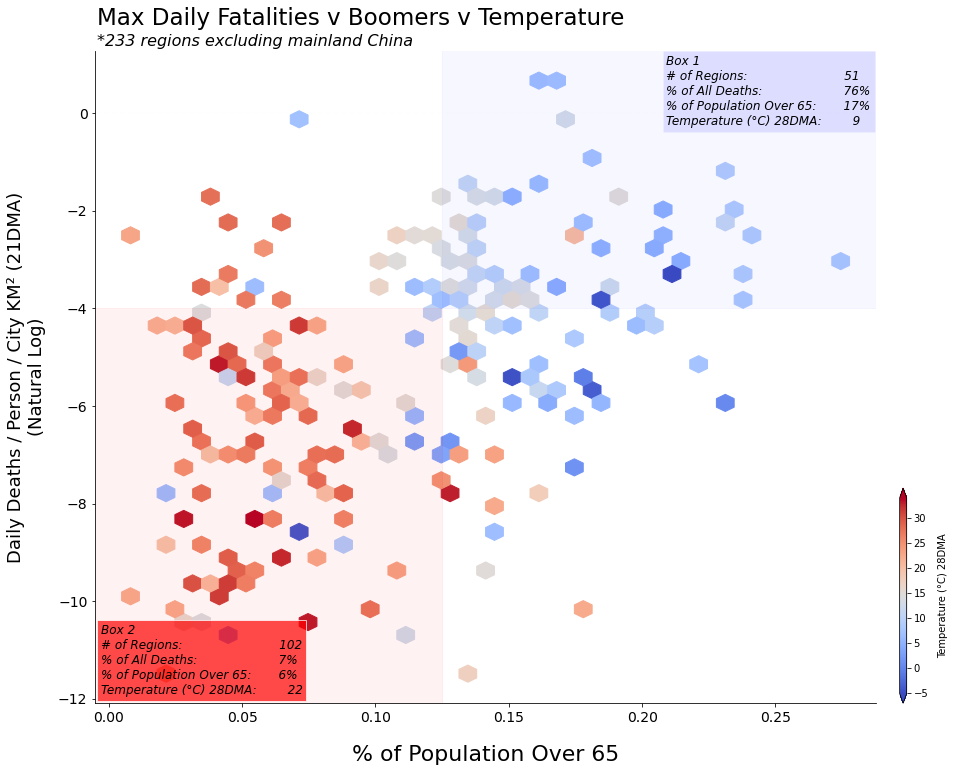

In [14]:
title = 'Max Daily Fatalities v Boomers v Temperature'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)

kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'comp_factor': 'A65PLUSB_%',
    'color_factor': 'temp_dma',
    'color_factor_start': 'start_hurdle',
    'annotations': [
        [-4460, 129.5, title, {'color': 'black', 'fontsize': 23, 'ha': 'left', 'va': 'center',}],
        [-4460, 125, note, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
    ],
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 22, 'fs_ylabel': 18, 'fs_clabel': 10,
    'width': 14, 'height': 12,
    'hlines': [0], 'hline_alpha': .01,
    'hexsize': 40,
}
box_range = (0.125, -4)
box_date = '2020-05-05'
kwargs['rects'] = [
    {
        'text': True, 'x_text': -1299, 'y_text': 115, 'ha': 'left', 'alpha': .1, 'factor_in_the_box': 'color_factor',
        'inverse': False,
        'date': box_date, 'dirxn': 'greater', 'args': [box_range, 27, 80], 'kwargs': dict(color='blue', alpha=0.03)
    },
    {
        'text': True, 'x_text': -4440, 'y_text': 1.6, 'ha': 'left', 'alpha': 0.7, 'factor_in_the_box': 'color_factor',
        'inverse': False,
        'date': box_date, 'dirxn': 'lesser', 'args': [box_range, -40, -10], 'kwargs': dict(color='red', alpha=0.05)
    }
]
plt = casestudy.heatmap.make(**kwargs)

In the above chart, we can see that **76%** of all deaths from COVID19 came in regions with more than 12.5% of their population 65 or older. Those regions also had an average temperature 9C.

In stark contrast, the most low risk regions had low population age and warmer temperatures, averaging 22C.

We can see this correlation even more clearly by transposing the axes a bit. We'll now put `A65PLUSB` on the y-axis, `temp_dma` on the x-axis, and color-map to the max fatality rate.

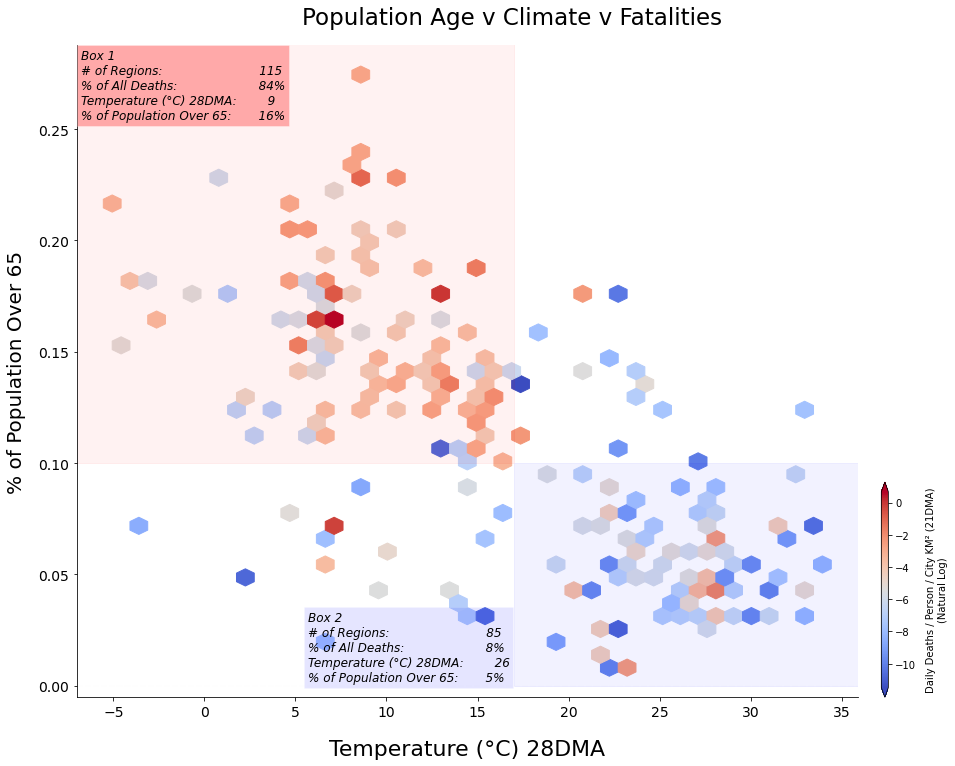

In [23]:
title = 'Population Age v Climate v Fatalities'
note = '*{} regions excluding mainland China'.format(casestudy.df.region_name.unique().size)

kwargs = {
    'comp_category': 'A65PLUSB_%',
    'comp_factor': 'temp_dma',
    'color_factor': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'color_factor_start': 'max',
    'annotations': [
        [-650, 30.1, title, {'color': 'black', 'fontsize': 23, 'ha': 'center', 'va': 'center',}],
#         [-1395, 29.1, note, {'color': 'black', 'fontsize': 10, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
    ],
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 22, 'fs_ylabel': 20, 'fs_clabel': 10,
    'width': 14, 'height': 12,
    'hlines': [0], 'hline_alpha': .01,
    'hexsize': 40,
    'save_file': True,
    'filename': '/Users/spindicate/Documents/docs/covid19/charts/Age v Temperature v Fatalities.png'
}
box_range = (17, 0.1)
box_date = '2020-05-06'
kwargs['rects'] = [
    {
        'text': True, 'x_text': -1395, 'y_text': 25.9, 'ha': 'left', 'alpha': 0.3, 'factor_in_the_box': 'comp_category',
        'inverse': True,
            'date': box_date, 'dirxn': 'greater', 'args': [box_range, -30, .25], 'kwargs': dict(color='red', alpha=0.05)
    },
    {
        'text': True, 'x_text': -1003, 'y_text': -9, 'ha': 'left', 'alpha': .1, 'factor_in_the_box': 'comp_category',
        'inverse': True,
        'date': box_date, 'dirxn': 'lesser', 'args': [box_range, 22, -0.1], 'kwargs': dict(color='blue', alpha=0.05)
    },
]
plt = casestudy.heatmap.make(**kwargs)

From the above we can see that **84%** of all fatalities due to COVID19 occured in regions with ***10%*** of population or more 65 or older and temperature less than ***17C***.

We can also see from the chart above that population age and average temperature appear to be correlated.

So the question is ... is COVID impacted by only temperature, only population age, or a bit of both?

## Heart Disease

Below we can see heart disease may have some correlation to cases.

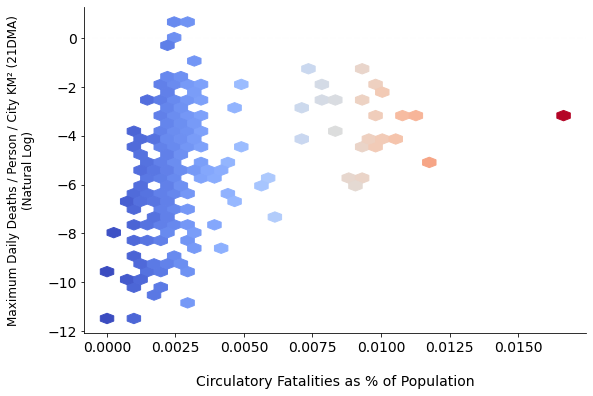

In [187]:
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat',
    'comp_factor': 'circul_%',
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 14, 'fs_ylabel': 12, 'fs_clabel': 10,
    'width': 9, 'height': 6,
    'hlines': [0], 'hline_alpha': .01,
    'hexsize': 34,
}

plt = casestudy.heatmap.make(**kwargs)

As per below, however, the prevelance of heart disease is pretty strongly correlated with population age ... so is heart disease causing greater deaths, or just old age in general?

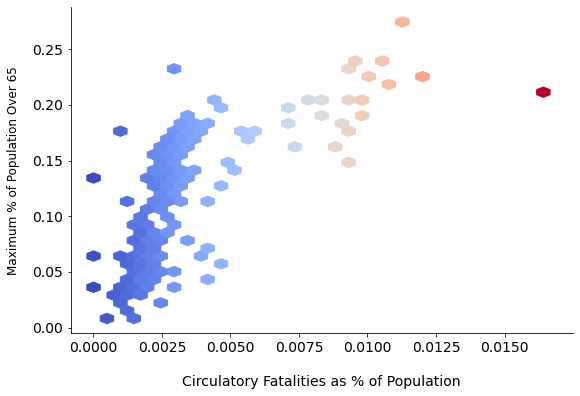

In [188]:
kwargs = {
    'comp_category': 'A65PLUSB_%',
    'comp_factor': 'circul_%',
    'fs_xticks': 14, 'fs_yticks': 14,
    'fs_xlabel': 14, 'fs_ylabel': 12, 'fs_clabel': 10,
    'width': 9, 'height': 6,
    'hlines': [0], 'hline_alpha': .01,
    'hexsize': 34,
}

plt = casestudy.heatmap.make(**kwargs)

# International Travel and GDP

**To be continued ...**

# Next Section

Click on this link to go to the next notebook: [04 - Linear Regression](04%20-%20See19%20-%20Linear%20Regression.ipynb)